### Reference 

 http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Quote from original paper:

*In the comparison of chest X-rays presenting as pneumonia versus normal, we achieved an accuracy of 92.8%, with* 

*a sensitivity of 93.2% and a specificity of 90.1%. The area under the ROC curve for detection of pneumonia from* 

*normal was 96.8%.*

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from fastai import *
from fastai.vision import *

### Constants, funcs and loads

In [3]:
bs = 64

In [4]:
path = Path('/home/ubuntu/Data/pneunonia/chest_xray/')

In [5]:
path.ls()

[PosixPath('/home/ubuntu/Data/pneunonia/chest_xray/train'),
 PosixPath('/home/ubuntu/Data/pneunonia/chest_xray/models'),
 PosixPath('/home/ubuntu/Data/pneunonia/chest_xray/valid'),
 PosixPath('/home/ubuntu/Data/pneunonia/chest_xray/.DS_Store')]

### Looking at the data

In [8]:
doc(ImageDataBunch.from_folder)

In [6]:
%%time
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=False), size=224, bs=bs)
data.normalize(imagenet_stats)

CPU times: user 84 ms, sys: 12 ms, total: 96 ms
Wall time: 84.2 ms


In [7]:
data.valid_ds, data.train_ds

(DatasetTfm(ImageClassificationDataset of len 624),
 DatasetTfm(ImageClassificationDataset of len 5232))

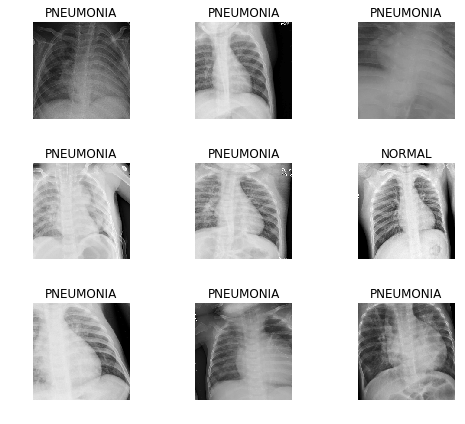

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
print(data.classes)

['NORMAL', 'PNEUMONIA']


In [10]:
# sanity check
sum(data.valid_ds.ds.y)

390

In [12]:
! ls {path/'valid'/'PNEUMONIA'} | wc -l

390


###  Training

In [20]:
doc(create_cnn)

In [13]:
learn = create_cnn(data=data, arch=models.resnet34, metrics=accuracy)

In [14]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


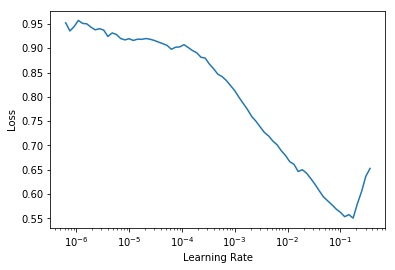

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, 3e-3)

Total time: 06:32
epoch  train_loss  valid_loss  accuracy
1      0.258268    0.528489    0.833333  (01:39)
2      0.146672    0.344240    0.879808  (01:37)
3      0.086714    0.304936    0.892628  (01:37)
4      0.070775    0.259289    0.900641  (01:37)



In [17]:
learn.save('stage-1')

In [19]:
learn.load('stage-1')

### Interpriting results

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

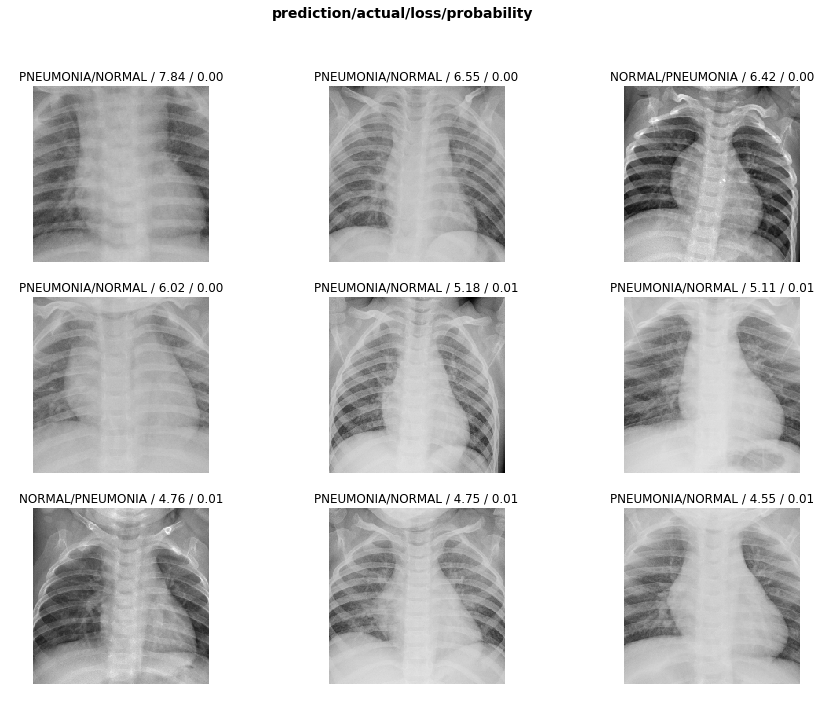

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

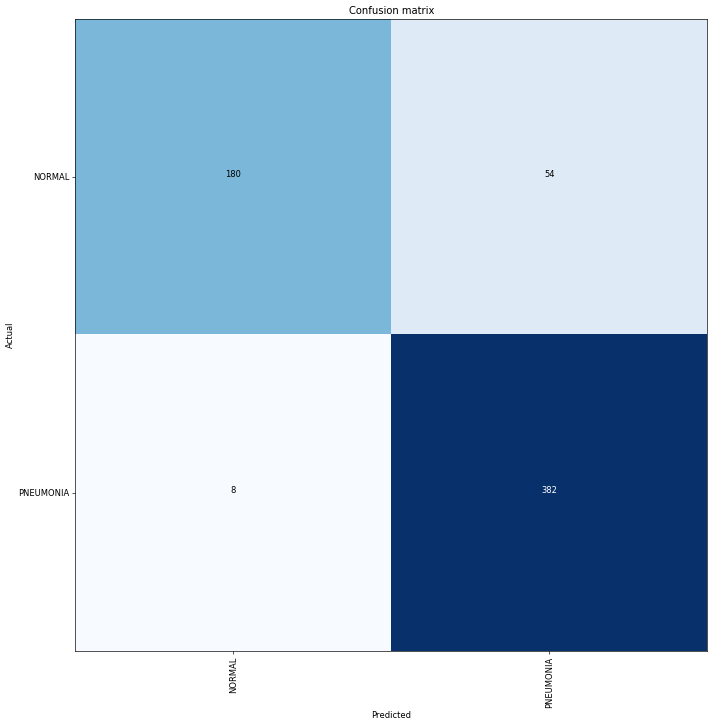

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Unfreezing, fine-tuning, and learning rates

In [23]:
learn.unfreeze()

In [24]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


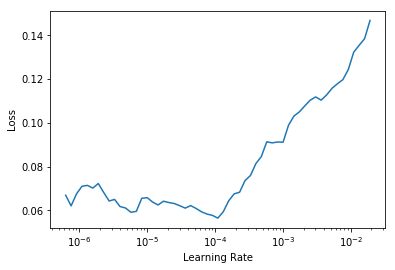

In [25]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

Total time: 03:18
epoch  train_loss  valid_loss  accuracy
1      0.060968    0.297594    0.899038  (01:39)
2      0.057550    0.281467    0.897436  (01:39)



In [27]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

Total time: 03:18
epoch  train_loss  valid_loss  accuracy
1      0.056170    0.266945    0.899038  (01:39)
2      0.064243    0.270726    0.900641  (01:39)



In [28]:
learn.save('stage-2')

### Training: resnet50 

In [6]:
%%time
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=False), size=320, bs=bs//2)
data.normalize(imagenet_stats)

CPU times: user 76 ms, sys: 20 ms, total: 96 ms
Wall time: 82.9 ms


In [7]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


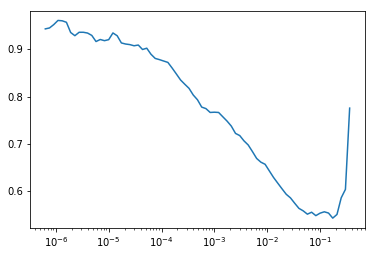

In [67]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6, max_lr=slice(3e-3)) # TODO: decrease max_lr

epoch,train_loss,valid_loss,accuracy
1,0.200307,0.316295,0.878205
2,0.134518,0.431432,0.871795
3,0.096466,0.398888,0.873397
4,0.075637,0.370429,0.868590


In [ ]:
learn.save('stage-1-50')